# Airbnb_Seattle Analysis-Udacity

In [1]:
#Importing required libraries for the project
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltt
import seaborn as sns
%matplotlib inline
from IPython import display
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor#import sys
#reload(sys)
#sys.setdefaultencoding("utf-8")

/jupyterhub_env/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Gathering data

In [2]:
#Reading the data sets and displaying the top rows of it

reviews = pd.read_csv("reviews.csv")
calendar = pd.read_csv("calendar.csv")
listings = pd.read_csv("listings.csv")
listings.head()
 


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


# Assessing Data 

In [3]:
 #Checking the dimensions of data sets
print("Deimensions of dataframes, rows, columns \n", 
      "Calendar : ", calendar.shape, "\n",
      "Listings : ", listings.shape, "\n",
      "Reviews : ", reviews.shape,)

Deimensions of dataframes, rows, columns 
 Calendar :  (1393570, 4) 
 Listings :  (3818, 92) 
 Reviews :  (84849, 6)


In [4]:
 listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

 Cleaning data set- Handling missing data:

In [5]:
listings['Washer'] = listings.amenities.str.contains('washer', case=False)
listings['Dryer'] = listings.amenities.str.contains('dryer', case=False)
listings['PetFriendly'] = listings.amenities.str.contains('pet|dog|cat', case=False)
listings['Internet'] = listings.amenities.str.contains('internet|wireless', case=False)
listings['TV'] = listings.amenities.str.contains("tv", case=False)
listings['AirCond'] = listings.amenities.str.contains('air condition|air conditioning', case=False)

Exploring the missing values- Data Visualization

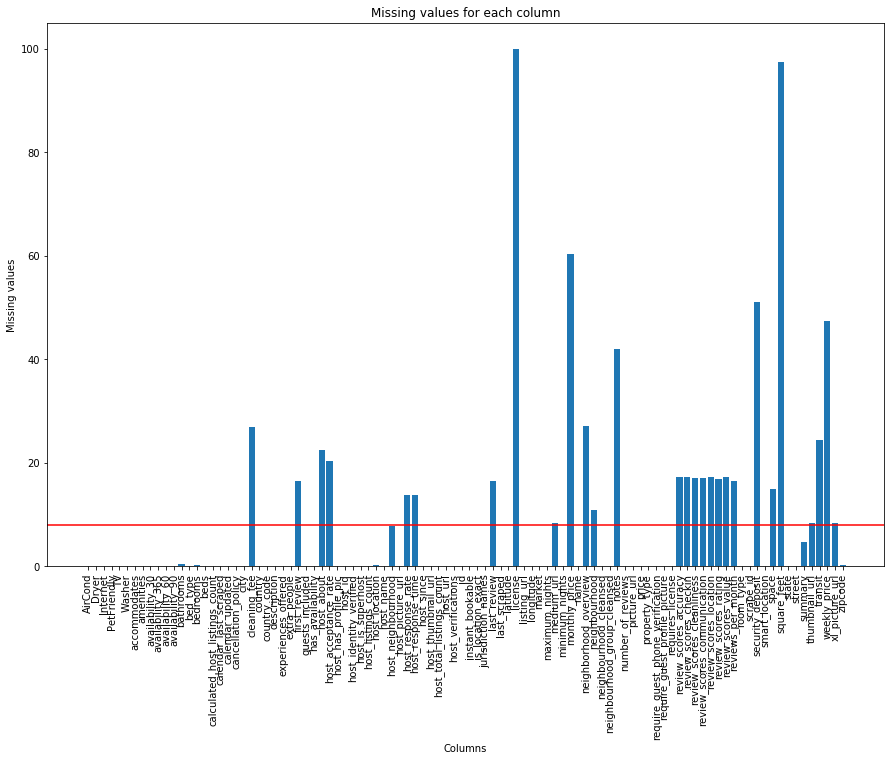

In [6]:
mis_pct = [(listings[series].isnull().sum()/len(listings[series]))*100 for series in list(listings) ]
miss_header = [series for series in list(listings)  ]

mean = np.mean(mis_pct)
fig, ax = plt.pyplot.subplots(figsize=(15,10))
plt.pyplot.title("Missing values for each column")
plt.pyplot.xlabel("Columns")
plt.pyplot.ylabel("Missing values")
plt.pyplot.axhline(y=mean, c='r', label='"Mean"')

plt.pyplot.bar(miss_header, mis_pct)
plt.pyplot.xticks(rotation=90);

We observed that the threshold for outliers is 20%. Removeing the columns which have more than 20% of missing values:

# Cleaning Data

In [7]:
#Removing columns: This function is to identify the outlier columns. This function takes data frame and threshold as parameters

def remove_outlier_col(df, threshold):
    """
    This is the function written for identifying outlier columns. 
    The input for this function is dataframe and outlier threshold and return two lists. 
    The 1st list identifies the columns and 2nd contains coresponding number of missing values
    """
    outlier_columns = []
    outlier_value = []
    for i in list(df):
        if ((df[i].isnull().sum() / len(df[i])) > threshold):
           
            outlier_columns.append(i)
            outlier_value.append(df[i].isnull().sum())
        
    return outlier_columns, outlier_value

In [8]:
outlier_col, outlier_value = remove_outlier_col(listings, 0.2)

In [9]:
for i in zip(outlier_col, outlier_value):
    print(i)

('neighborhood_overview', 1032)
('notes', 1606)
('transit', 934)
('host_about', 859)
('host_acceptance_rate', 773)
('square_feet', 3721)
('weekly_price', 1809)
('monthly_price', 2301)
('security_deposit', 1952)
('cleaning_fee', 1030)
('license', 3818)


In [10]:
#Dropping unwanted columns
listings.drop(outlier_col, axis=1, inplace=True)

Handling categorical values:

In [11]:
#The column host_listings_count is same as  host_total_listings_count. The column of Scrape_id contains same value in all the rows.
listings.drop(['scrape_id', 'host_listings_count'], axis=1, inplace=True)

In [12]:
list(listings.select_dtypes(include=['object']))

['listing_url',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'amenities',
 'price',
 'extra_people',
 'calendar_updated',
 'has_availability',
 'calendar_last_scraped',
 'first_review',
 'last_review',
 'requires_license',
 'jurisdiction_names',
 'instant_bookable',
 'cancellation_policy',
 'require_guest_profile_picture',
 'require_guest_phone_verification']

# Analysing data

In [13]:
#Encoding categorical columns:
making_numeric = ['extra_people' ,'host_response_rate', 'price' ]

one_hot_encoding = ['host_response_time', 'host_is_superhost','cancellation_policy', 'room_type', 'instant_bookable','neighbourhood_group_cleansed', 'property_type', 'bed_type', 
                  'host_identity_verified']
    


In [14]:
#Additional changes in columns:
# Convert to numeric values
listings.host_response_rate = listings.host_response_rate.str.replace("%", "")
listings.host_response_rate = pd.to_numeric(listings.host_response_rate)

listings.price = listings.price.str.replace("$", "")
listings.price = listings.price.str.replace(",", "")
listings.price = pd.to_numeric(listings.price)


listings.extra_people = listings.extra_people.str.replace("$", "")
listings.extra_people = pd.to_numeric(listings.extra_people);


In [15]:
list(listings.select_dtypes(include=['object']));

In [16]:
dropping_object = [i for i in list(listings.select_dtypes(include=['object'])) if i not in making_numeric + one_hot_encoding]

dropping_num = ['review_scores_communication', 'review_scores_location','id', 'host_id', 'latitude', 'longitude', 'review_scores_accuracy', 'review_scores_cleanliness',
             'reviews_per_month', 'calculated_host_listings_count','review_scores_checkin','review_scores_value', ]



In [17]:
listings.drop(dropping_num + dropping_object, axis=1, inplace=True)

Visualizing correlations through heatmap

Question 1: Acheiving best price 

# Data VIsualization

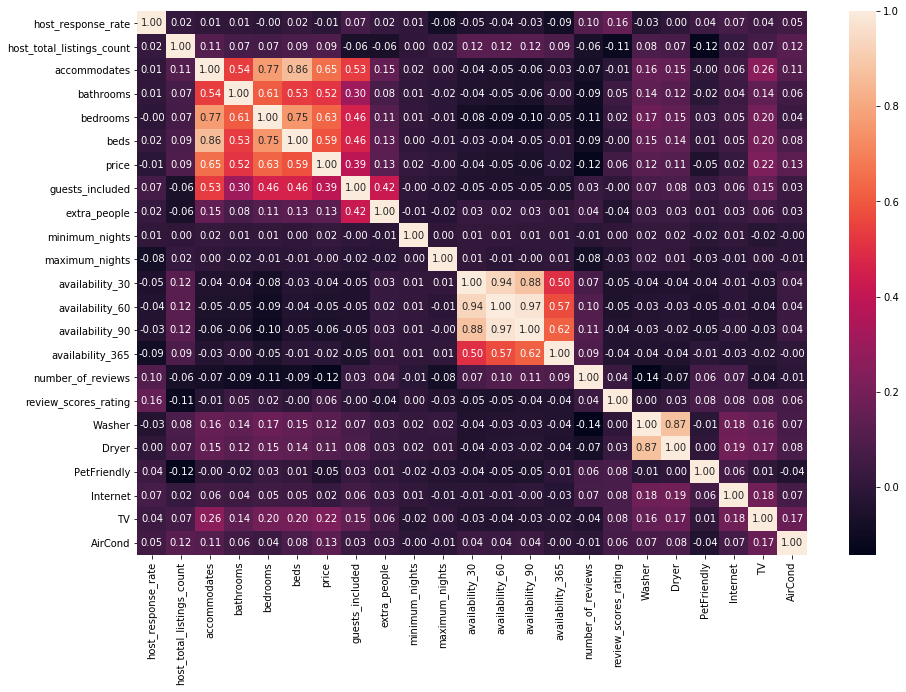

In [19]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

Here, we can observe that few columns have very high correlation
Now, we need to drop few columns to make the predictive machine learning model more robust 
Assuming the threshold of correlation to be .6, we shall remove the column crossing that correlation

In [20]:
highcorr_columns = [ 'availability_60', 'availability_90','beds', 'bedrooms', 'availability_365', 'Dryer']

listings.drop(highcorr_columns, axis=1, inplace=True)

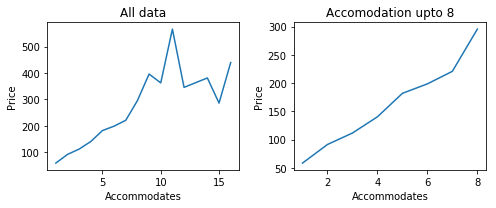

In [21]:
accommodate = pd.DataFrame(listings.groupby("accommodates")['price'].mean(), columns=['price'])

f,a = plt.pyplot.subplots(figsize=(7,3))
plt.pyplot.subplot(1,2,1)
plt.pyplot.title("All data")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accommodate)

plt.pyplot.subplot(1,2,2)
plt.pyplot.title("Accomodation upto 8")
plt.pyplot.ylabel("Price")
plt.pyplot.xlabel("Accommodates")
plt.pyplot.plot(accommodate[:8])

plt.pyplot.tight_layout();


In [22]:
# Drop listings that can accommodate more than 8 people as its very noisy 
listings = listings[listings.accommodates <= 8]

New Heatmap

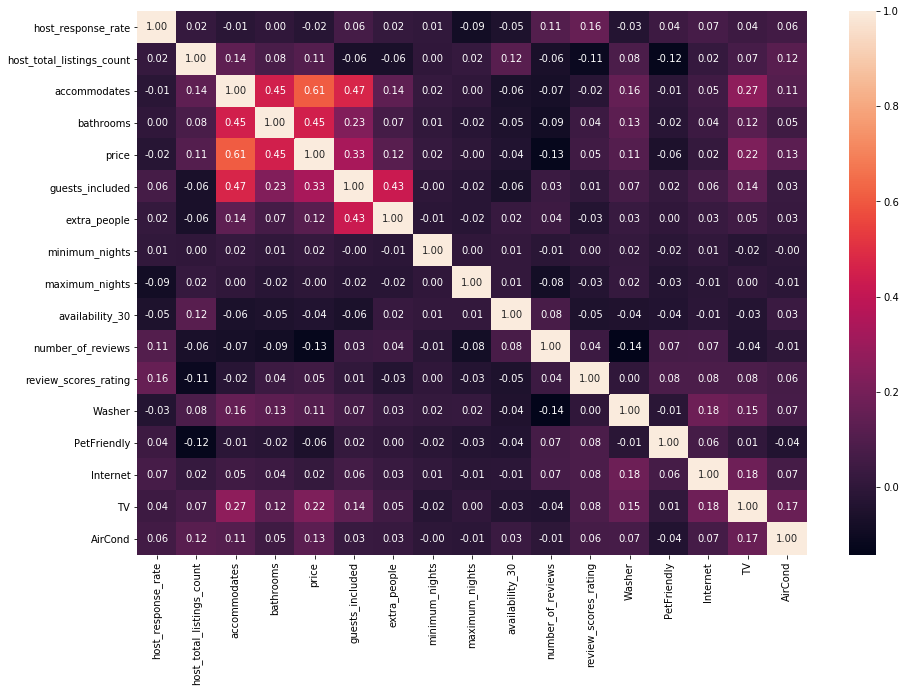

In [23]:
fig, ax = plt.pyplot.subplots(figsize=(15,10))
sns.heatmap(listings.corr(), annot=True, fmt='.2f');

Question 2: Top ezpensive localities in Seattle

Analysis of most used words in Airbnb description

/jupyterhub_env/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


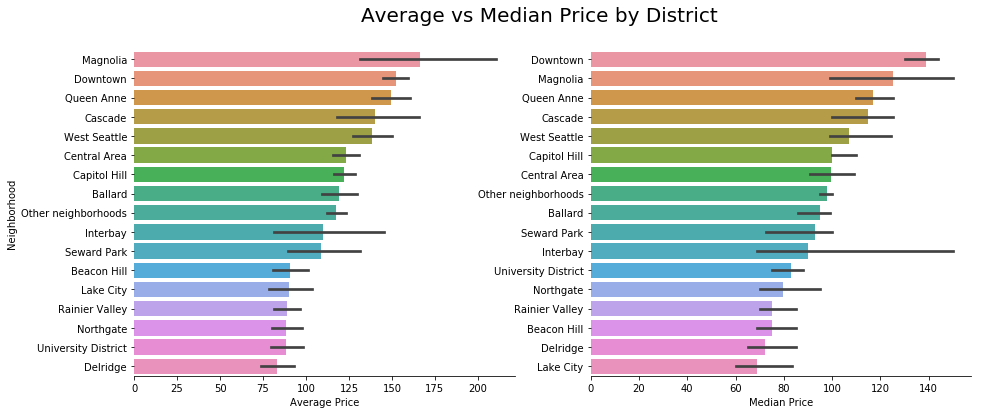

In [24]:
fig, (ax1, ax2) = pltt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle("Average vs Median Price by District", fontsize=20)
rank = listings.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False).index
sns.barplot(x='price', y='neighbourhood_group_cleansed', data=listings, order=rank, ax=ax1)
ax1.set_ylabel("Neighborhood")
ax1.set_xlabel("Average Price")
rank = listings.groupby('neighbourhood_group_cleansed')['price'].median().sort_values(ascending=False).index
sns.barplot(x='price', y='neighbourhood_group_cleansed', data=listings, estimator=np.median, order=rank, ax=ax2)
ax2.set_ylabel("")
ax2.set_xlabel("Median Price")
sns.despine(left=True)

/jupyterhub_env/lib/python3.5/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


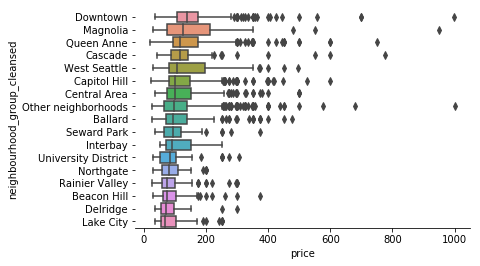

In [25]:
sns.boxplot(x='price', y='neighbourhood_group_cleansed', data=listings, order=rank)
sns.despine(left=True)

Question3: Price Prediction with Machine Learning

# Data Modelling

In [26]:
# One hot encode categorical features before machine learning
listings_encoding = pd.get_dummies(listings, drop_first=True);

In [27]:
# Split dataset into subsets for different handling of missing values
full_df = listings_encoding.dropna().copy()

imputed_df = listings_encoding.copy()
for col in imputed_df:
    imputed_df[col].fillna(imputed_df[col].value_counts().index[0], inplace=True)

In [28]:
# Split into targets and features
target = full_df.price.copy()
features = full_df.drop('price', axis=1).copy()

target_imp = imputed_df.price.copy()
features_imp = imputed_df.drop('price', axis=1).copy()

In [29]:
# Split to training set and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(features_imp, target_imp, test_size=0.25)

Algorithm1: Support Vector Machine

In [30]:
scaler = preprocessing.StandardScaler()

scaled_x = scaler.fit_transform(X_train)
test_x = scaler.transform(X_test)
scaled_x_imp = scaler.fit_transform(X_train_imp)
test_x_imp = scaler.transform(X_test_imp)

In [31]:
param_dist_svm = {
 'kernel': ['linear', 'rbf', 'poly'],
 'C' : [0.001,0.05,0.1]

 }

svmmodel = GridSearchCV(svm.SVC(), param_grid=param_dist_svm )
svmmodel.fit(scaled_x_imp, y_train_imp)

/jupyterhub_env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf', 'poly'], 'C': [0.001, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
svmpred = svmmodel.predict(test_x_imp)
r2_score(y_test_imp, svmpred)

0.14975979563797948

Algorithm 2: Random Forest

In [33]:
from scipy.stats import randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": randint(3,15),
              "n_estimators" : [100, 1000],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "min_samples_leaf" : randint(1,10)
                            }
n_iter_search = 20
randommodel = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
randommodel.fit(X_train_imp, y_train_imp);

In [34]:
pred = randommodel.predict(X_test_imp)

In [35]:
r2_score(y_test_imp, pred)

0.5400489648384177

Hence it can be concluded that Random Forest can explain atleast 54% pf price variance.